In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [3]:
y.index = y.name

In [4]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

In [5]:
y.index = pd.to_datetime(y.index)

In [6]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)

In [7]:
y.head()

,BasicEPS
1985-09-30,0.0
1985-12-31,0.004
1986-03-31,0.002
1986-06-30,0.002
1986-09-30,0.0


# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [8]:
from pytrends.request import TrendReq

In [9]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["iPhone", "Recession", "Samsung", "Interest Rates", "New Phone", "Buy iPhone", "Sell iPhone", "Android", "Amazon", "Best Buy", "Black Friday", "iPad", "Mac", "Water", "Ronaldo", "Daylight Savings"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [10]:
X = df.resample("Q").mean()

In [11]:
# ALIGN DATA
temp = pd.concat([y, X],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

# 3.) Normalize all the X data

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

In [14]:
X_scaled

array([[-1.83115076, -0.76991448, -1.72785119, ..., -0.52672856,
        -1.85134401,  0.01032706],
       [-1.83115076, -0.75074548, -1.763375  , ...,  0.04722394,
        -1.48515429, -0.42897016],
       [-1.83115076, -0.82742149, -1.56799404, ...,  0.04722394,
        -0.75277483, -0.80551063],
       ...,
       [ 0.54113868,  0.8594507 , -0.11151779, ...,  1.69081518,
         1.55422045,  0.95167824],
       [ 0.29741031,  0.59108467, -0.25361303, ...,  1.87343643,
         0.56550819, -1.15067273],
       [ 0.8011156 ,  0.07352162,  0.01281555, ...,  2.02996893,
         0.34579435, -0.67999714]])

In [15]:
X.values

array([[ 0.        ,  7.66666667, 24.66666667, ..., 61.        ,
         5.33333333, 15.33333333],
       [ 0.        ,  8.        , 24.        , ..., 68.33333333,
         8.66666667, 10.66666667],
       [ 0.        ,  6.66666667, 27.66666667, ..., 68.33333333,
        15.33333333,  6.66666667],
       ...,
       [48.66666667, 36.        , 55.        , ..., 89.33333333,
        36.33333333, 25.33333333],
       [43.66666667, 31.33333333, 52.33333333, ..., 91.66666667,
        27.33333333,  3.        ],
       [54.        , 22.33333333, 57.33333333, ..., 93.66666667,
        25.33333333,  8.        ]])

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [16]:
from sklearn.linear_model import Lasso

In [17]:
Lasso = Lasso(alpha = 0.5)

In [18]:
model = Lasso.fit(X_scaled, y)

In [19]:
predictions = model.predict(np.array(X_scaled))

In [20]:
coefficients = model.coef_

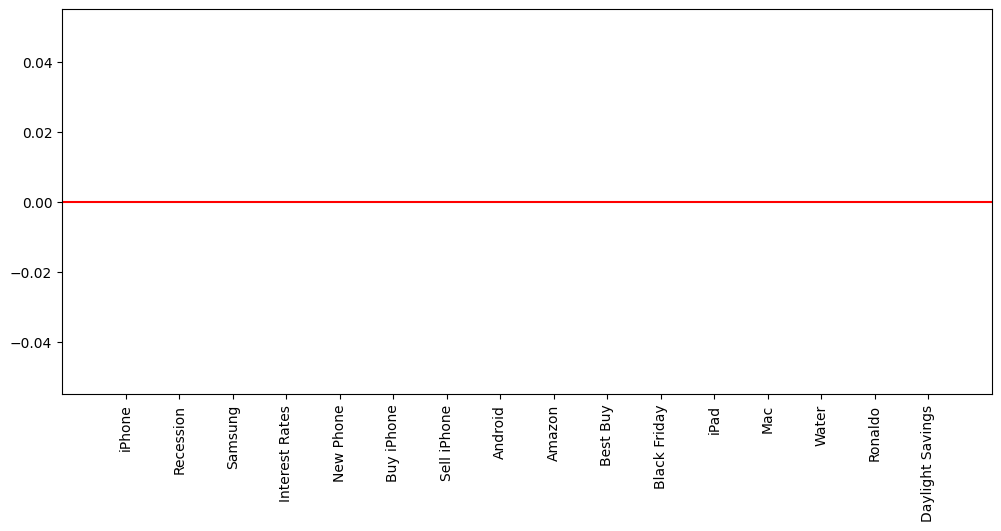

In [21]:
plt.figure(figsize = (12,5))
plt.bar(range(len(coefficients)), coefficients)
plt.xticks(ticks = range(0,len(X.columns)) ,labels = list(X.columns), rotation = 'vertical')
plt.axhline(0, color = "red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?

By using a Lambda of 0.5, it looks like all the coefficients have been shrunk to 0. This suggests that the keywords chosen are all weak predictors of Apple's earnings per shares.  

The 0 values of the coefficients might have been due to the normalization of the X data. Usually, we would need to normalize the X data when the predictors are off different scales to avoid more importance being placed on the predictors or larger scales. However, since all our predictors are internet search interests, they would have the same scale and thus normalizing them might not be necessary. We can try to run the lasso again without normalizing to see if the results are different.

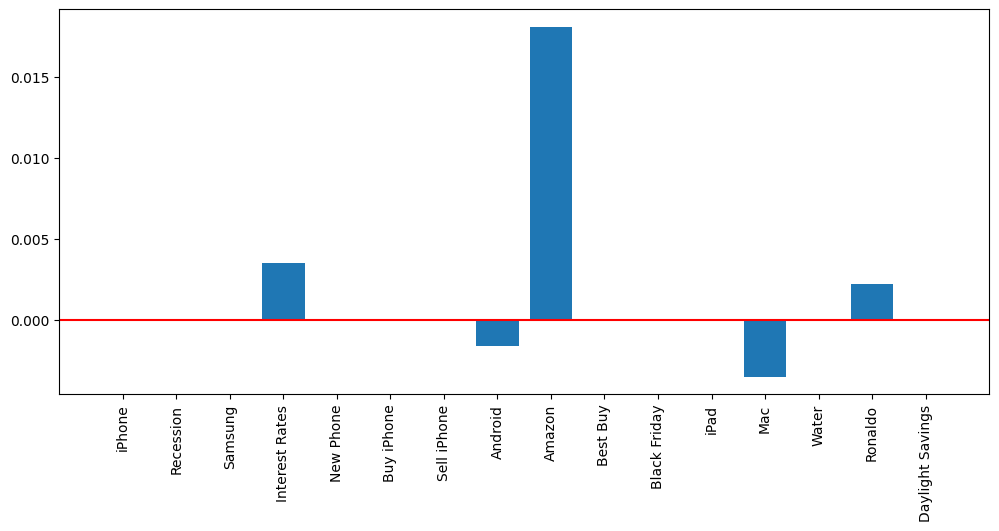

In [22]:
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha = 0.5)
model = Lasso.fit(X.values, y)
predictions = model.predict(np.array(X_scaled))
coefficients = model.coef_
plt.figure(figsize = (12,5))
plt.bar(range(len(coefficients)), coefficients)
plt.xticks(ticks = range(0,len(X.columns)) ,labels = list(X.columns), rotation = 'vertical')
plt.axhline(0, color = "red")
plt.show()

When running the lasso again without normalizing the data, we notice that most of the predictors have been shrunk to 0. The predictor Amazon has the highest positive coefficient, which would make sense as many people make their purchases on amazon and people of frequent amazon might be more likely to purchase apple products, especially if they see any good deals on the platform. Interest rates, according to the model, is a weak positive predictor of apple's earnings. A relationship between consumer's interest in interest rates also makes sense, as higher interest rates typically have a negative effect on earnings, and people searching for interest rates might be deciding whether to save their money or spend it based on the current interest rates. Ronaldo being a weak positive predictor of apple's earnings is quite surprising, as he is a professional athelete and should have no correlation to apple's earnings.  

Android is a weak negative predictor of apple's earnings, which makes sense as android phones are the main competitor of iphones. Mac being a negative predictor of apple's earnings is surpising since Macs are apple's line of desktop computers, though this relation may be due to the fact that the term "Mac" can mean a few other things besides Macintosh computers, such as the lipstick brand of Mcdonald's Big Mac burgers.